In [1]:
import IPython
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette('Set1'))
sns.set_style("whitegrid")

import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

#Importing dataframe
df = pd.read_csv("Datasets/hotel_bookings.csv")
city_df = df[df['hotel'] == 'City Hotel'].reset_index(drop=True).drop('hotel',axis=1)
city_df['total_booked_nights'] = city_df['stays_in_weekend_nights'] + city_df['stays_in_week_nights']

In [2]:
city_df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_booked_nights
0,0,6,2015,July,27,1,0,2,1,0.0,...,6.0,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-03,2
1,1,88,2015,July,27,1,0,4,2,0.0,...,9.0,NaN,0,Transient,76.5,0,1,Canceled,2015-07-01,4
2,1,65,2015,July,27,1,0,4,1,0.0,...,9.0,NaN,0,Transient,68.0,0,1,Canceled,2015-04-30,4
3,1,92,2015,July,27,1,2,4,2,0.0,...,9.0,NaN,0,Transient,76.5,0,2,Canceled,2015-06-23,6
4,1,100,2015,July,27,2,0,2,2,0.0,...,9.0,NaN,0,Transient,76.5,0,1,Canceled,2015-04-02,2


### Missing values

In [3]:
(city_df['company'].isnull().sum()/len(city_df))

0.9534980461363923

In [4]:
#Dropping problematic columns
city_df.drop(['company','agent'],axis=1,inplace=True)

#Removing rows with NaN values in 'Country' column
city_df.dropna(subset=['country'],inplace=True)

#Filling children with O as NaN problaby means that there was no children
city_df['children'].fillna(0,inplace=True)

There should be no missing values in the dataframe now. 

### Encoding

I am going to use Label Encoding, just to keep the model simple and fast to compute. In general for not ordinal feature, better choice would be probably One Hot Encoding.

In [5]:
#Creating list of categorical columns
cat_columns = [col for col in city_df.columns if city_df[col].dtype == object]
num_columns = city_df.select_dtypes(include=np.number).columns.tolist()

#Label encoding - function definition
def label_encoder(dataframe,columns):
    le = LabelEncoder()
    for column in dataframe[columns].columns:
        dataframe[column] = le.fit_transform(dataframe[column].astype(str))
        
#Label encoding 
label_encoder(city_df,cat_columns)

# Printing number of unique values for categorical features
city_df[cat_columns].nunique() 

arrival_date_month          12
meal                         4
country                    166
market_segment               8
distribution_channel         5
reserved_room_type           8
assigned_room_type           9
deposit_type                 3
customer_type                4
reservation_status           3
reservation_status_date    864
dtype: int64

In [6]:
# Adding 'reservation_status_date' as the numerical variable as it differs a lot
num_columns.append('reservation_status_date')

### Outliers detection

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. 

Therea are two kinds of outliers: 
- univariate: can be found when looking at a distribution of values in a single feature space
- multivariate: an be found in a n-dimensional space (of n-features)

There are two different approaches/techniques that can be used based on a distribution of values. If it is **parametric**, we can use techniques such as Z-Score or Extreme Value Analysis. For **non-parametric** it is better to use one of the proximity based models (e.g. Dbscan or Isolation Forest). 

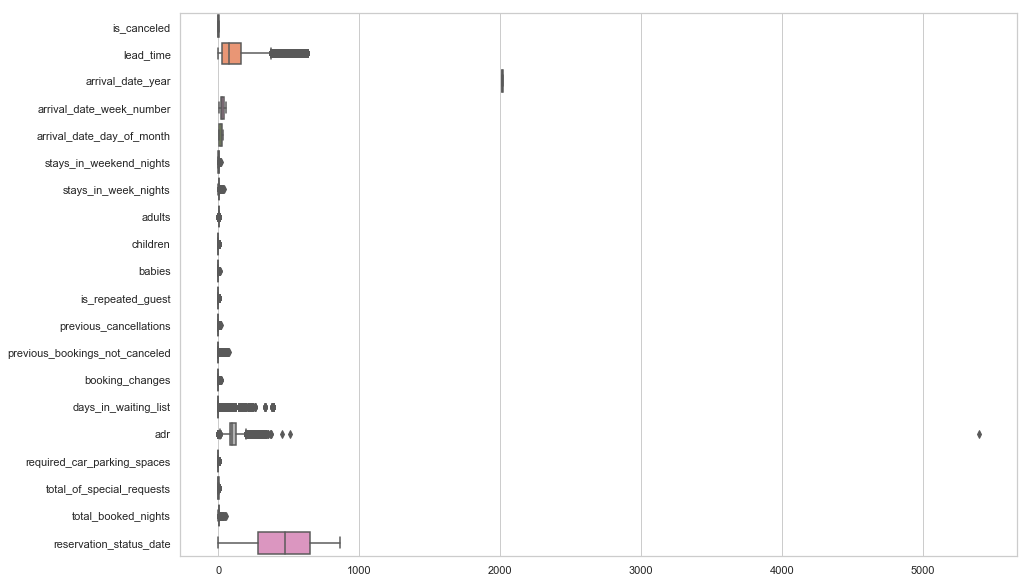

In [7]:
#Plotting barplot for all numerical variables to detect possible outliers
plt.figure(figsize=(15,10))
sns.boxplot(data=city_df[num_columns], orient="h", palette="Set2")

Based on these information, we can assume that there are some significat outliers within **'adr'** variable. Outliers in 'lead_time' could be crucial for creating a model as based on the intuition, cancelation ratio is higher for higher 'lead_time'. I decided to take a better look at few other variables to make a decision about the final approach. 

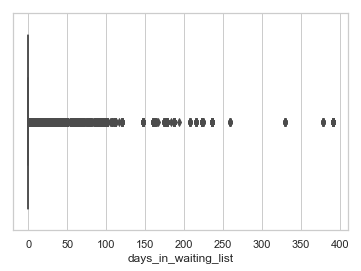

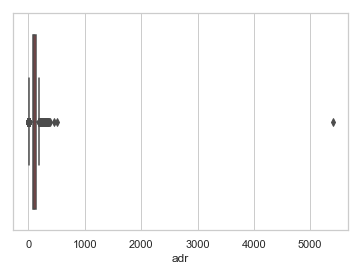

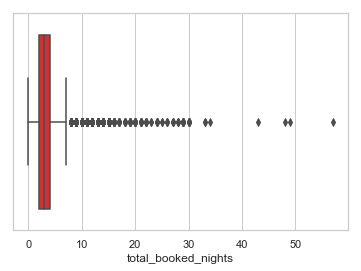

In [8]:
#Creating list of variables problematic because of outliers
possible_outliners = ['days_in_waiting_list','adr','total_booked_nights']

#Plotting problematic variables
for column in city_df[possible_outliners]:
    plt.figure()
    sns.boxplot(x=column,data=city_df)
    

At first we will handle variable 'total_booked_nights' in order to detect univariate outliers. Many hotels have regulations that limit total nights number that can be booked in row. We do not have this information for the hotel that we are considering, so we will try to predict it with outliers detection. We will do the same for 'days_in_waitinglist', as it looks like there are some possible data entry errors. I am going to use single feature Isolation Forest as none of these variables are parametrically distributed. We will keep the same method for 'adr' feature and finally I run a multivariate outliers detection script to remove outliers. 

In [9]:
# Setting up IsolationForest function
def isolationforest_detect(dataframe,columns,contamination,outlier_name='Outliers'):
    
    clf = IsolationForest(max_samples='auto', random_state=1, contamination=contamination)
    
    if type(columns) is list:
        preds = clf.fit_predict(dataframe[columns])
    else:
        preds = clf.fit_predict(dataframe[columns].values.reshape(-1,1))
            
    dataframe[outlier_name] = preds
        
    print(dataframe[outlier_name].value_counts())

In [10]:
# Creating multivariate outliers detection run to compare results with single feature approach
isolationforest_detect(city_df,['adr','days_in_waiting_list','total_booked_nights'],0.05,'combined_outliers')

 1    75342
-1     3964
Name: combined_outliers, dtype: int64


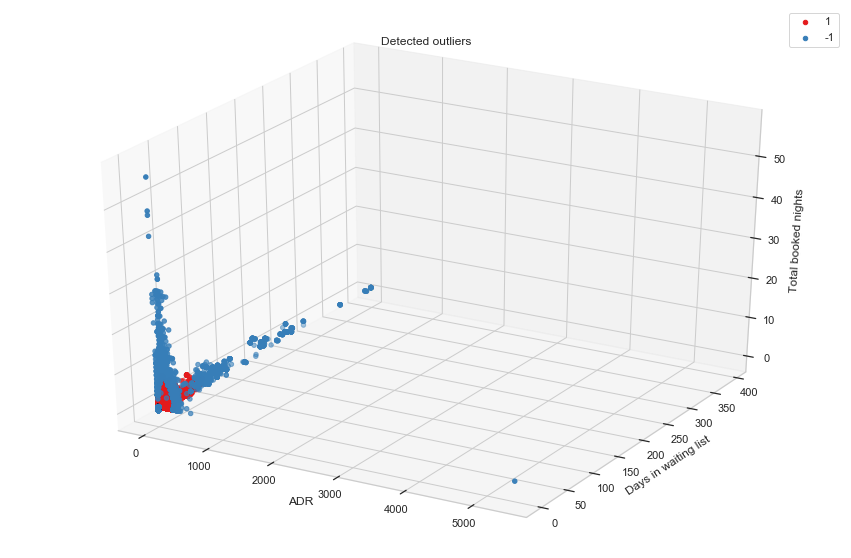

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection = '3d')
for i in city_df.combined_outliers.unique():
    ax.scatter(city_df.adr[city_df.combined_outliers==i],
               city_df.days_in_waiting_list[city_df.combined_outliers==i],
               city_df.total_booked_nights[city_df.combined_outliers==i],
               label=i)
ax.set_title('Detected outliers')
ax.set_ylabel('Days in waiting list')
ax.set_xlabel('ADR')
ax.set_zlabel('Total booked nights')
ax.legend()

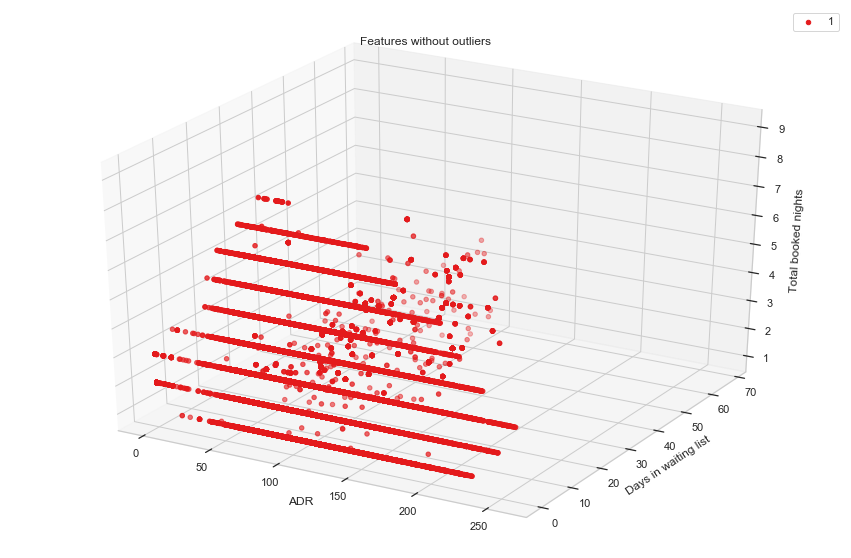

In [12]:
#Removing outliers
city_df = city_df[(city_df['combined_outliers'] != -1)]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection = '3d')
for i in city_df.combined_outliers.unique():
    ax.scatter(city_df.adr[city_df.combined_outliers==i],
               city_df.days_in_waiting_list[city_df.combined_outliers==i],
               city_df.total_booked_nights[city_df.combined_outliers==i],
               label=i)
ax.set_title('Features without outliers')
ax.set_ylabel('Days in waiting list')
ax.set_xlabel('ADR')
ax.set_zlabel('Total booked nights')
ax.legend()               

After running 3-dimensional Isolation Forest we managed to remove outliers and wee see that these features have reduced range and are more organized than before in general. 

In [13]:
# Removing unnecessary column
city_df.drop('combined_outliers', inplace=True, axis=1)

### Feature scaling
Many classifiers (like KNN, K-means) calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. So the range of features should be scaled so that each feature contributes approximately proportionately to the final distance. Scaling also decrease the average time of running gradient descent. 

1. Normalization - features will be rescaled so that the data will fall in the range of [0,1]
2. Standarization - features will have the properties of a standard normal distribution with mean,μ=0 and standard deviation, σ=1; where μ is the mean (average) and σ is the standard deviation from the mean.

Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks. Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. Tree-based algorithms, on the other hand, are fairly insensitive to the scale of the features.

However to check all options I will prepare 3 variants of city_df and its numerical variables to: **raw, normalized, standardized**.


In [14]:
# Columns for scaling
binary_columns = ['is_canceled']
columns_to_scale = [i for i in city_df.columns if i not in binary_columns]

# Creating copy of city_df
raw_city_df = city_df.copy()

# Creating normalized city_df
normalized_city_df = city_df.copy()
normalized_city_df[columns_to_scale] = MinMaxScaler().fit_transform(normalized_city_df[columns_to_scale])

# Creating standardized city_df
standardized_city_df = city_df.copy()
standardized_city_df[columns_to_scale] = StandardScaler().fit_transform(standardized_city_df[columns_to_scale])

### Feature selection

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Irrelevant or partially relevant features can negatively impact model performance.

Benefits:
- Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
- Improves Accuracy: Less misleading data means modeling accuracy improves.
- Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.



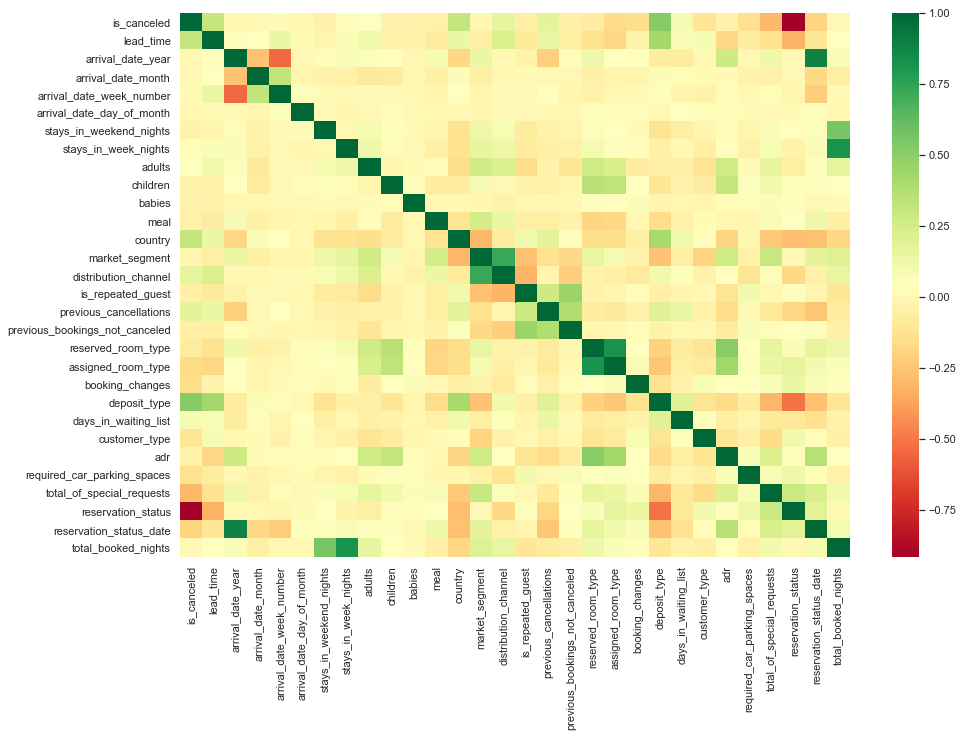

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(raw_city_df.corr(),cmap="RdYlGn")

In [16]:
# Printing the features based on descending correlation
city_df.corr()["is_canceled"].abs().nlargest(10).sort_values(ascending=False)[1:]

reservation_status           0.915736
deposit_type                 0.518594
lead_time                    0.310701
country                      0.305001
total_of_special_requests    0.296028
reservation_status_date      0.197032
previous_cancellations       0.176787
assigned_room_type           0.163896
distribution_channel         0.161315
Name: is_canceled, dtype: float64

It looks like 'reservation_status' feature is determining the outcome as it is stores almost the same information as target variable. I am going to remove this feature, as in the real world the final reservation status will be known after arrival date.

In [17]:
city_df.drop('reservation_status', axis=1, inplace=True)
normalized_city_df.drop('reservation_status', axis=1, inplace=True)
standardized_city_df.drop('reservation_status', axis=1, inplace=True)

#### Univariate feature selection
*Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.* - sklearn

In [18]:
# Checking feature according to k highest score.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

y = city_df.iloc[:,0]
X = city_df.iloc[:,1:]

# Appling SelectKBest class to extract top 10 best features with chi-squared stat
features_selector = SelectKBest(score_func=chi2, k=10)
features = features_selector.fit(X,y)

# Creating a dataframe for better visualization 
feature_scores = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(features.scores_)],axis=1)
feature_scores.columns = ['Variable','Score']
print(feature_scores.nlargest(10,'Score'))

                          Variable          Score
0                        lead_time  814013.361111
26         reservation_status_date  321959.371102
11                         country  151901.791301
21            days_in_waiting_list   27105.424956
20                    deposit_type   17023.334988
25       total_of_special_requests    7300.151158
18              assigned_room_type    5318.717087
15          previous_cancellations    4993.037862
16  previous_bookings_not_canceled    4122.659366
19                 booking_changes    3064.675842


#### Feature selection using  Tree-based estimator

*Tree-based estimators can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features*

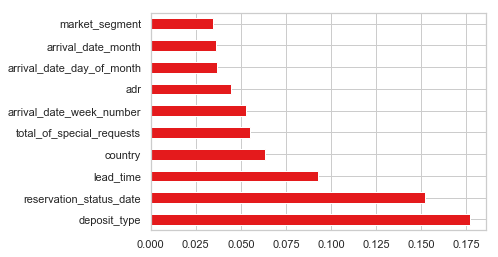

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)

pd.Series(model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')

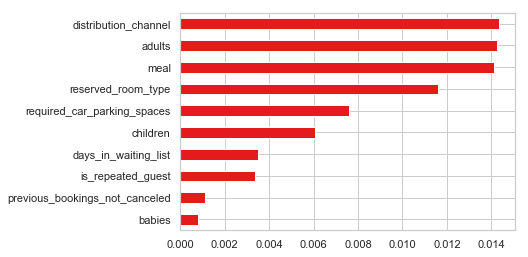

In [20]:
pd.Series(model.feature_importances_, index=X.columns).nsmallest(10).plot(kind='barh')

In [21]:
from sklearn.linear_model import LassoCV

y = standardized_city_df.iloc[:,0]
X = standardized_city_df.iloc[:,1:]

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X.columns)
feature_scores_LassoCV = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(importance)],axis=1)
feature_scores_LassoCV.columns = ['Variable','Score']
feature_scores_LassoCV[feature_scores_LassoCV['Score']==0]

,Variable,Score
6,stays_in_week_nights,0.0
9,babies,0.0


Based on LassoCV we can skip 'stays_in_week_nights' and 'babies' features as they do no have any impact on the cancelations prediction. 

### Summary

Based on operation above, I am going to create a preprocessing pipeline that will be used for creating a model. Outliers detection will be run separetely as